# Modèle avec du Transfert Learning

Modèle utilisé : **InceptionV3**

CNN pour aider à l'analyse d'image et à la detection d'objet. Développé par Google, 3ème version de l'*Inception Convolutional Neural Network*

##### **Ressources associées au modèle InceptionV3**
- https://fr.mathworks.com/help/deeplearning/ref/inceptionv3.html
- https://cloud.google.com/tpu/docs/inception-v3-advanced?hl=fr
- https://en.wikipedia.org/wiki/Inceptionv3

### Étapes de ce notebook
- Chargement du modèle InceptionV3
- Création d'un modèle à partir des couches de l'InceptionV3
- Entrainement de la dernière couche selon nos targets à partir des images
- Enregistrement du modèle et affichage des métriques

### Imports

In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from numpy import expand_dims
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Configuration des données

In [ ]:
nom_checkpoint_model = "model_Incept_20e120c_data"
nom_save_weight = "sauv_weights_Incept_20e120c_data"
sauv_dir = "/content/drive/MyDrive/TP_standford/Incept_20e120c_data/"
num_images=120

In [ ]:
train_data_dir = "/content/drive/MyDrive/TP_standford/data/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
image_arr_size= img_width * img_height * channels

### Phase de preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 16507 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [ ]:
# Nombre de classes (120 races)
num_classes = len(train_generator.class_indices)

# Encodage des labels de l'échantillon de train
# Ressource : https://stackoverflow.com/questions/41494625/issues-using-keras-np-utils-to-categorical/43314437
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)

# Encodage des labels de l'échantillon de validation
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

### Visualisation de la data augmentation

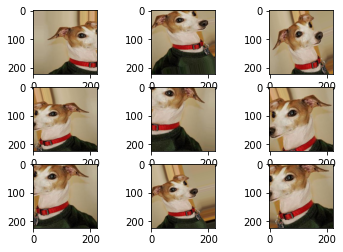

In [ ]:
# On prend une image aléatoirement : n02091032-Italian_greyhound/n02091032_55.jpg
img = load_img('/content/drive/MyDrive/TP_standford/data/n02091032-Italian_greyhound/n02091032_55.jpg')

# Conversion en array
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

# On affiche 9 images pour visualiser la data augmentation
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.show()

### Visualisation des labels (targets) = races

In [ ]:
# Visualisation des labels
label_maps = {}
for i, v in enumerate(train_generator.class_indices):
    label_maps.update({i:v})
print(f'{len(label_maps)} races')

120 races


In [ ]:
label_maps

{0: 'n02085620-Chihuahua',
 1: 'n02085782-Japanese_spaniel',
 2: 'n02085936-Maltese_dog',
 3: 'n02086079-Pekinese',
 4: 'n02086240-Shih-Tzu',
 5: 'n02086646-Blenheim_spaniel',
 6: 'n02086910-papillon',
 7: 'n02087046-toy_terrier',
 8: 'n02087394-Rhodesian_ridgeback',
 9: 'n02088094-Afghan_hound',
 10: 'n02088238-basset',
 11: 'n02088364-beagle',
 12: 'n02088466-bloodhound',
 13: 'n02088632-bluetick',
 14: 'n02089078-black-and-tan_coonhound',
 15: 'n02089867-Walker_hound',
 16: 'n02089973-English_foxhound',
 17: 'n02090379-redbone',
 18: 'n02090622-borzoi',
 19: 'n02090721-Irish_wolfhound',
 20: 'n02091032-Italian_greyhound',
 21: 'n02091134-whippet',
 22: 'n02091244-Ibizan_hound',
 23: 'n02091467-Norwegian_elkhound',
 24: 'n02091635-otterhound',
 25: 'n02091831-Saluki',
 26: 'n02092002-Scottish_deerhound',
 27: 'n02092339-Weimaraner',
 28: 'n02093256-Staffordshire_bullterrier',
 29: 'n02093428-American_Staffordshire_terrier',
 30: 'n02093647-Bedlington_terrier',
 31: 'n02093754-Border_

### Création du réseau de neurone

#### Chargement du modèle InceptionV3

In [ ]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

#### Création d'un modèle avec les couches de l'InceptionV3

In [ ]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))

# Ajout de la dernière couche avec num_classes (trainable=true)
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


#### Compilation du modèle

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

#### Phase d'entrainement du modèle

Après plusieurs tests et plusieurs lancements d'entrainement de CNN, j'ai ajouté : 
- un `ModelCheckpoint` pour sauvegarder le meilleur modèle à chaque epoch dans un fichier **.h5**
- un `EarlyStopping` pour lutter contre le surapprentissage!
- un `CSVLogger` qui permet de logger à chaque epoch les métriques du modèle (accuracy, loss, etc)
- un `ReduceLROnPlateau` pour agir sur le learning rate du modèle à chaque epoch

In [ ]:
checkpoint = ModelCheckpoint(
    sauv_dir+nom_checkpoint_model+'.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= sauv_dir+"training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

# On enregistre dans un tableau callbacks, qu'on va fournir lors de l'entrainement du modèle
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
%%time
history = model.fit(
    train_generator, 
    epochs = 20,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 1, 
    callbacks = callbacks
)

Epoch 1/20
257/257 [==============================] - 7898s 31s/step - loss: 4.0953 - accuracy: 0.1746 - val_loss: 1.3899 - val_accuracy: 0.7684

Epoch 00001: val_loss improved from inf to 1.38986, saving model to /content/drive/MyDrive/TP_standford/Incept_20e120c_data/model_Incept_20e120c_data.h5
Epoch 2/20
257/257 [==============================] - 1398s 5s/step - loss: 1.4216 - accuracy: 0.6983 - val_loss: 0.7186 - val_accuracy: 0.8331

Epoch 00002: val_loss improved from 1.38986 to 0.71864, saving model to /content/drive/MyDrive/TP_standford/Incept_20e120c_data/model_Incept_20e120c_data.h5
Epoch 3/20
257/257 [==============================] - 1427s 6s/step - loss: 0.9405 - accuracy: 0.7628 - val_loss: 0.5652 - val_accuracy: 0.8477

Epoch 00003: val_loss improved from 0.71864 to 0.56521, saving model to /content/drive/MyDrive/TP_standford/Incept_20e120c_data/model_Incept_20e120c_data.h5
Epoch 4/20
257/257 [==============================] - 1419s 6s/step - loss: 0.7881 - accuracy: 0.

### Affichage des métriques

In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

64/64 [==============================] - 251s 4s/step - loss: 0.4231 - accuracy: 0.8669
Validation Loss:  0.42314717173576355
Validation Accuracy:  0.866895854473114


### Visualisation en plot des courbes d'apprentissage

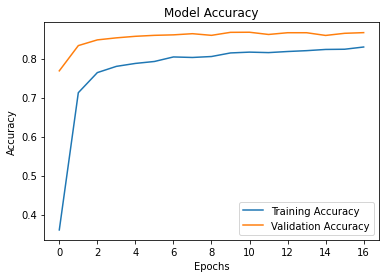

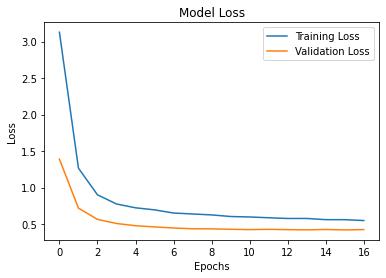

In [ ]:
# Graph 1 : évolution de l'accuracy selon le nombre d'epoch
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

# Graph 2 : évolution du loss selon le nombre d'epoch
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

### Enregistrement des poids du modèle

In [ ]:
model.save_weights(sauv_dir+nom_save_weight+'/ckpt')